In [70]:
import numpy as np
import tensorflow as tf
# 查询系统可用的 GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# 确保有可用的 GPU 如果没有, 则会报错
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# 设置参数,该段务必在运行jupyter的第一段代码执行，否则会无法初始化成功
# 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [71]:
!nvidia-smi

Tue Mar  2 19:56:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   1516MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### 回调函数
- 1.modelCheckpoint:定期保存模型，epoch在多轮训练的时候，选择最好的那一个迭代
- 2.EarlyStopping:当训练不再改善验证精度时，停止训练
- 3.TensorBoard：定期编写可以在TensorBoard中可视化的模型日志
- 4.CSVLogger:将损失和指标数据流失传输到CSV文件

#### 一、构建模型

In [14]:
inputs = tf.keras.Input(shape=(32,)) # batch_size =32,数据维度32
x = tf.keras.layers.Dense(64,activation='relu')(inputs) # 64个神经元
x = tf.keras.layers.Dense(64,activation='relu')(x) # 64个神经元
predictions = tf.keras.layers.Dense(10)(x) # 输出是10个类别

In [15]:
model = tf.keras.Model(inputs = inputs,outputs = predictions)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), # 优化器
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #损失函数
    metrics=['accuracy'] # 评估指标
)

time：11：35分钟

##### 优化方法

- SGD 随机梯度下降
- RMsprop RMSProp算法修改了AdaGrad的梯度积累为指数加权的移动平均，使得其在非凸设定下效果更好
- Adam  Adam中动量直接并入了梯度一阶矩（指数加权）的估计。其次，相比于缺少修正因子导致二阶矩估计可能在训练初期具有很高偏置的RMSProp，Adam包括偏置修正，修正从原点初始化的一阶矩（动量项）和（非中心的）二阶矩估计

##### 损失函数
- MeanSquaredError()  MSE 回归类问题，均方误差
- KLDivergence() 相对熵
- CosineSimilartity() 余弦相似度

##### 评估指标
- AUC()
- Precision()
- Recall()

In [17]:
model.compile(optimizer= 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [18]:
# 构建一个演示数据集

# 训练集 维度上是1000行32列
x_train = np.random.random((1000,32))
y_train = np.random.randint(10,size=(1000,))

# 验证集
x_val = np.random.random((200,32))
y_val = np.random.randint(10,size=(200,))

# 测试集
x_test = np.random.random((200,32))
y_test= np.random.randint(10,size=(200,))

In [19]:
x_train.shape

(1000, 32)

In [20]:
x_train[0]

array([0.20449132, 0.1975686 , 0.80928921, 0.5394343 , 0.42300131,
       0.63197378, 0.19005393, 0.92601474, 0.75346541, 0.7342906 ,
       0.29627854, 0.8841611 , 0.69747024, 0.36605237, 0.4505487 ,
       0.9277736 , 0.11461863, 0.37643944, 0.00758247, 0.71428418,
       0.19966066, 0.41385345, 0.68470047, 0.59788165, 0.33746268,
       0.64075095, 0.03410188, 0.37450414, 0.45580944, 0.39890817,
       0.71948955, 0.88197208])

In [21]:
y_train[0]

6

#### 二、模型训练 model.fit()

通过对数据切分成大小为batch_size的批来训练模型，并针对给定数量的epoch重复遍历整个数据集

In [22]:
model.fit(x_train,y_train,batch_size = 32, epochs = 5, validation_data = (x_val,y_val)) # 选择定义好的验证集

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 2.3261 - accuracy: 0.1080 - val_loss: 2.3149 - val_accuracy: 0.0800
Epoch 2/5
32/32 [==============================] - 0s 4ms/step - loss: 2.2942 - accuracy: 0.1250 - val_loss: 2.3164 - val_accuracy: 0.0800
Epoch 3/5
32/32 [==============================] - 0s 4ms/step - loss: 2.2819 - accuracy: 0.1310 - val_loss: 2.3165 - val_accuracy: 0.0800
Epoch 4/5
32/32 [==============================] - 0s 4ms/step - loss: 2.2724 - accuracy: 0.1450 - val_loss: 2.3247 - val_accuracy: 0.0850
Epoch 5/5
32/32 [==============================] - 0s 4ms/step - loss: 2.2634 - accuracy: 0.1660 - val_loss: 2.3217 - val_accuracy: 0.1050


- batch_size :使用32个样本来更新一次模型的参数
- epochs:把1000个数据按照32个样本一份分为了大概32次迭代，那么着32次迭代就会跑完1次数据，这样就构成了一个epochs
- 案例中定义了5个epochs，表示将所有数据重复的跑了5次，总量上就是5*32次迭代

In [23]:
# 对训练集选择0.3的比例为验证集
# steps_per_epoch 每一个epochs用到多少个batch_size
model.fit(x_train,y_train,batch_size = 32, epochs = 5, validation_split= 0.3,steps_per_epoch=1)

Epoch 1/5
1/1 [==============================] - 0s 104ms/step - loss: 2.2943 - accuracy: 0.1250 - val_loss: 2.2457 - val_accuracy: 0.1800
Epoch 2/5
1/1 [==============================] - 0s 47ms/step - loss: 2.1848 - accuracy: 0.2500 - val_loss: 2.2454 - val_accuracy: 0.1800
Epoch 3/5
1/1 [==============================] - 0s 46ms/step - loss: 2.3144 - accuracy: 0.1250 - val_loss: 2.2456 - val_accuracy: 0.1800
Epoch 4/5
1/1 [==============================] - 0s 41ms/step - loss: 2.2698 - accuracy: 0.1250 - val_loss: 2.2467 - val_accuracy: 0.1833
Epoch 5/5
1/1 [==============================] - 0s 43ms/step - loss: 2.2633 - accuracy: 0.2188 - val_loss: 2.2479 - val_accuracy: 0.1700


#### 三、模型验证 model.evaluate()

In [24]:
print('评估在测试集上的性能指标')
results = model.evaluate(x_test,y_test,batch_size=128,)

评估在测试集上的性能指标
2/2 [==============================] - 0s 2ms/step - loss: 2.3007 - accuracy: 0.1200


In [25]:
print('测试集损失，测试集Acc:',results)

测试集损失，测试集Acc: [2.300654411315918, 0.11999999731779099]


#### 四、模型预测 model.predict()

In [26]:
print('执行预测并预览预测结果')
predictions = model.predict(x_test[:3])
print('预测的结果大小：',predictions.shape)

执行预测并预览预测结果
预测的结果大小： (3, 10)


In [27]:
predictions

array([[ 0.37829632, -0.02912606, -0.540003  ,  0.22380704,  0.25971514,
         0.15607199, -0.06335844,  0.30316254, -0.39182064,  0.15053897],
       [ 0.24765144, -0.17345326, -0.2545616 , -0.01297516,  0.10108391,
        -0.19110554,  0.17803864,  0.02543664,  0.01004085,  0.00629119],
       [ 0.3423071 ,  0.0938712 , -0.19881077, -0.0720029 ,  0.10443874,
        -0.00575284,  0.0157479 ,  0.13835591, -0.15527758,  0.21150878]],
      dtype=float32)

#### 五、使用样本加权和类别加权

样本加权：例如当模型中的所有数据中，有20%的数据的标签不确定较大，而另外80%的数据的标签确定性很充分，那么就可以对80%的样本进行加权，让模型更加关注该类样本的分类正确率（存在伪标签）

类别加权：当某一类的样本较少的时候，可以通过类别加权产生更多的类别

In [28]:
def get_umcompiled_model():
    inputs = tf.keras.Input(shape=(32,),name = 'digits')
    x = tf.keras.layers.Dense(64,activation = 'relu',name = 'dense_1')(inputs)
    x = tf.keras.layers.Dense(64,activation = 'relu',name = 'dense_2')(x)
    outputs = tf.keras.layers.Dense(10,name = 'predictions')(x)
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    return model

In [29]:
# 定义优化方法、指标
def get_compiled_model():
    model = get_umcompiled_model()
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['sparse_categorical_accuracy']
    )
    return model

In [30]:
# 加权类别5的权重
class_weight = {0:1,1:1,2:1,3:1,4:1,5:2,6:1,7:1,8:1,9:1}

In [31]:
print('通过类别加权训练数据')
model = get_compiled_model()
model.fit(x_train,y_train,class_weight = class_weight
    , batch_size = 64, epochs =4
)

通过类别加权训练数据
Epoch 1/4
16/16 [==============================] - 0s 3ms/step - loss: 2.5234 - sparse_categorical_accuracy: 0.1080
Epoch 2/4
16/16 [==============================] - 0s 3ms/step - loss: 2.4941 - sparse_categorical_accuracy: 0.0980
Epoch 3/4
16/16 [==============================] - 0s 3ms/step - loss: 2.4812 - sparse_categorical_accuracy: 0.1030
Epoch 4/4
16/16 [==============================] - 0s 3ms/step - loss: 2.4708 - sparse_categorical_accuracy: 0.1040


In [32]:
# 样本加权
sample_weight = np.ones(shape = (len(y_train),))
sample_weight[y_train == 5] = 2 # 对其中一个类别进行加权
print('通过样本加权进行训练')
model = get_compiled_model()
model.fit(x_train,y_train,sample_weight = sample_weight
    , batch_size = 64, epochs =4
)


通过样本加权进行训练
Epoch 1/4
16/16 [==============================] - 0s 4ms/step - loss: 2.5386 - sparse_categorical_accuracy: 0.0890
Epoch 2/4
16/16 [==============================] - 0s 3ms/step - loss: 2.4971 - sparse_categorical_accuracy: 0.1020
Epoch 3/4
16/16 [==============================] - 0s 3ms/step - loss: 2.4845 - sparse_categorical_accuracy: 0.0970
Epoch 4/4
16/16 [==============================] - 0s 3ms/step - loss: 2.4758 - sparse_categorical_accuracy: 0.1100


In [73]:
sample_weight[0:100]

array([1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 1., 2., 1., 2., 1., 2., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### 六、使用回调函数

keras的回调是在训练期间（某个阶段开始的时候，批处理结束的时候，某个阶段结束的时候等）在不同时间点调用的对象，主要可以实现的功能如下：
- 在训练过程的不同时间点进行验证
- 定期或在超过特定精度阈值的时候对模型进行检查，及早停止
- 训练迭代没有进步的时候，更改模型的学习率
- 训练迭代没有进步的时候，对顶层进行微调
- 在以上描述的情况出现的时候，回调可以作为列表传递给model.fit

#### 1. earlystopping
- monitor:被监测的数据
- min_delta:在被检测的数据中被认为是提升的最小变化，例如，小于该值的绝对变化视为性能没有提升
- patience：没有进步的训练轮数，在这一轮之后的训练会被停止
- verbose:显示详细的信息参数
- mode:auto\min\max三个选项，min是指数据停止下降时，训练停止；max是指被检测的数据停止上升的时候训练停止；auto是指方向会自动从被监测的数据的名字中判断出来

In [34]:
model = get_compiled_model()

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=2,
        verbose=1
    )
]

In [36]:
model.fit(x_train,y_train,epochs=20,batch_size=64
    , callbacks = callbacks
    ,validation_split=0.2
)

Epoch 1/20
13/13 [==============================] - 0s 11ms/step - loss: 2.3106 - sparse_categorical_accuracy: 0.1175 - val_loss: 2.3479 - val_sparse_categorical_accuracy: 0.0950
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 2.2910 - sparse_categorical_accuracy: 0.1462 - val_loss: 2.3571 - val_sparse_categorical_accuracy: 0.0800
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 2.2831 - sparse_categorical_accuracy: 0.1587 - val_loss: 2.3449 - val_sparse_categorical_accuracy: 0.0900
Epoch 00003: early stopping


#### 更多内置的回调函数
- ModelCheckpoint:定期保存模型
- EarlyStopping:当训练不再改善指标的时候，停止训练。
- TensorBoard：定期编写可在tensorboard中可视化的模型日志（更多详细信息颗参考可视化部分官方文档）
- CSVLogger:将损失和指标数据流式传输到CSV文件

#### 2.checkpoint模型
- 在相对较大的数据集中训练模型的时候，最重要的是要定期保存模型的checkpoint
- 最简单的方法是使用ModelCheckpoint回调

In [37]:
model = get_compiled_model()

In [39]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath = './dir22/ModelCheckpoint/mymodel_{epoch}',
    save_best_only =True, # 当模型val_loss分数提升时，才会保存当前检查点
    monitor = 'val_loss',
    save_weights_only=True, # 仅仅保存模型权重
    verbose=1
)
]

In [40]:
model.fit(x_train,y_train,epochs=20,batch_size=64
    , callbacks = callbacks
    ,validation_split=0.2
)

Epoch 1/20
 1/13 [=>............................] - ETA: 0s - loss: 2.3800 - sparse_categorical_accuracy: 0.0781
Epoch 00001: val_loss improved from inf to 2.30148, saving model to ./dir22/ModelCheckpoint/mymodel_1
13/13 [==============================] - 0s 20ms/step - loss: 2.3238 - sparse_categorical_accuracy: 0.0988 - val_loss: 2.3015 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/20
 1/13 [=>............................] - ETA: 0s - loss: 2.3013 - sparse_categorical_accuracy: 0.1562
Epoch 00002: val_loss did not improve from 2.30148
13/13 [==============================] - 0s 6ms/step - loss: 2.2937 - sparse_categorical_accuracy: 0.1238 - val_loss: 2.3066 - val_sparse_categorical_accuracy: 0.0900
Epoch 3/20
 1/13 [=>............................] - ETA: 0s - loss: 2.2668 - sparse_categorical_accuracy: 0.1719
Epoch 00003: val_loss did not improve from 2.30148
13/13 [==============================] - 0s 6ms/step - loss: 2.2821 - sparse_categorical_accuracy: 0.1412 - val_loss: 2.30

#### 3.使用回调实现动态学习率调整
- 由于优化程序无法访问验证指标，因此无法使用这些计划对象来实现动态学习率计划（如当验证损失不再改善时降低学习率）。
- 但是回调确实可以访问所有指标，包含验证指标，因此可以通过使用回调来修改优化程序上的当前学习率，从而实现该功能。实际上，它内置于ReduceLROnPlateau。

ReduceLROnPlateau 参数
- monitor：被监控的指标
- factor：学习率被降低的因数，新的学习率= 学习率*因数
- patience:没有进步的训练轮数，在这之后训练速率会被降低
- verbose：更新信息的模式
- mode：同上面的注释
- min_delta：衡量最新的最佳阈值，仅关注重大变化
- cooldown：在学习速率被降低前，重新恢复正常操作之前等待的训练轮数。
- min_lr:学习速率的下边界

In [41]:
 model = get_compiled_model()

In [42]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
            filepath = './dir22/ReduceLROnPlateau/mymodel_{epoch}',
        save_best_only =True, # 当模型val_loss分数提升时，才会保存当前检查点
        monitor = 'val_loss',
        save_weights_only=True, # 仅仅保存模型权重
        verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_sparse_categorical_accuracy',
        verbose=1,
        mode = 'max',
        factor=0.5,
        patience=3
    )
    
]

In [43]:
model.fit(x_train,y_train,epochs=20,batch_size=64
    , callbacks = callbacks
    ,validation_split=0.2
)

Epoch 1/20
 1/13 [=>............................] - ETA: 0s - loss: 2.2752 - sparse_categorical_accuracy: 0.1094
Epoch 00001: val_loss improved from inf to 2.33879, saving model to ./dir22/ReduceLROnPlateau/mymodel_1
13/13 [==============================] - 0s 11ms/step - loss: 2.3203 - sparse_categorical_accuracy: 0.1075 - val_loss: 2.3388 - val_sparse_categorical_accuracy: 0.0900 - lr: 0.0010
Epoch 2/20
 1/13 [=>............................] - ETA: 0s - loss: 2.2674 - sparse_categorical_accuracy: 0.1875
Epoch 00002: val_loss improved from 2.33879 to 2.33237, saving model to ./dir22/ReduceLROnPlateau/mymodel_2
13/13 [==============================] - 0s 7ms/step - loss: 2.2960 - sparse_categorical_accuracy: 0.1400 - val_loss: 2.3324 - val_sparse_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 3/20
 1/13 [=>............................] - ETA: 0s - loss: 2.3000 - sparse_categorical_accuracy: 0.1562
Epoch 00003: val_loss did not improve from 2.33237
13/13 [==============================

#### 七、将数据传输到多输入多输出的模型

In [44]:
# 定义一个图像输入和一个时间序列输入
image_input = tf.keras.Input(shape = (32,32,3),name = 'img_input')
timeseries_input = tf.keras.Input(shape=(20,10),name = 'ts_input')

# 卷积
x1 = tf.keras.layers.Conv2D(3,3)(image_input)
x1 = tf.keras.layers.GlobalMaxPooling2D()(x1)

x2 = tf.keras.layers.Conv1D(3,3)(timeseries_input)
x2 = tf.keras.layers.GlobalMaxPooling1D()(x2)

x = tf.keras.layers.concatenate([x1,x2])

# 一个分数输出，一个是包含5个类别的概率分布输出
score_output = tf.keras.layers.Dense(1,name = 'score_output')(x)
class_output = tf.keras.layers.Dense(5,name = 'class_output')(x)

model = tf.keras.Model(inputs = [image_input,timeseries_input],
    outputs = [score_output,class_output]
)

In [45]:
help(tf.keras.utils.plot_model)

Help on function plot_model in module tensorflow.python.keras.utils.vis_utils:

plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)
    Converts a Keras model to dot format and save to a file.
    
    Arguments:
      model: A Keras model instance
      to_file: File name of the plot image.
      show_shapes: whether to display shape information.
      show_layer_names: whether to display layer names.
      rankdir: `rankdir` argument passed to PyDot,
          a string specifying the format of the plot:
          'TB' creates a vertical plot;
          'LR' creates a horizontal plot.
      expand_nested: Whether to expand nested models into clusters.
      dpi: Dots per inch.
    
    Returns:
      A Jupyter notebook Image object if Jupyter is installed.
      This enables in-line display of the model plots in notebooks.



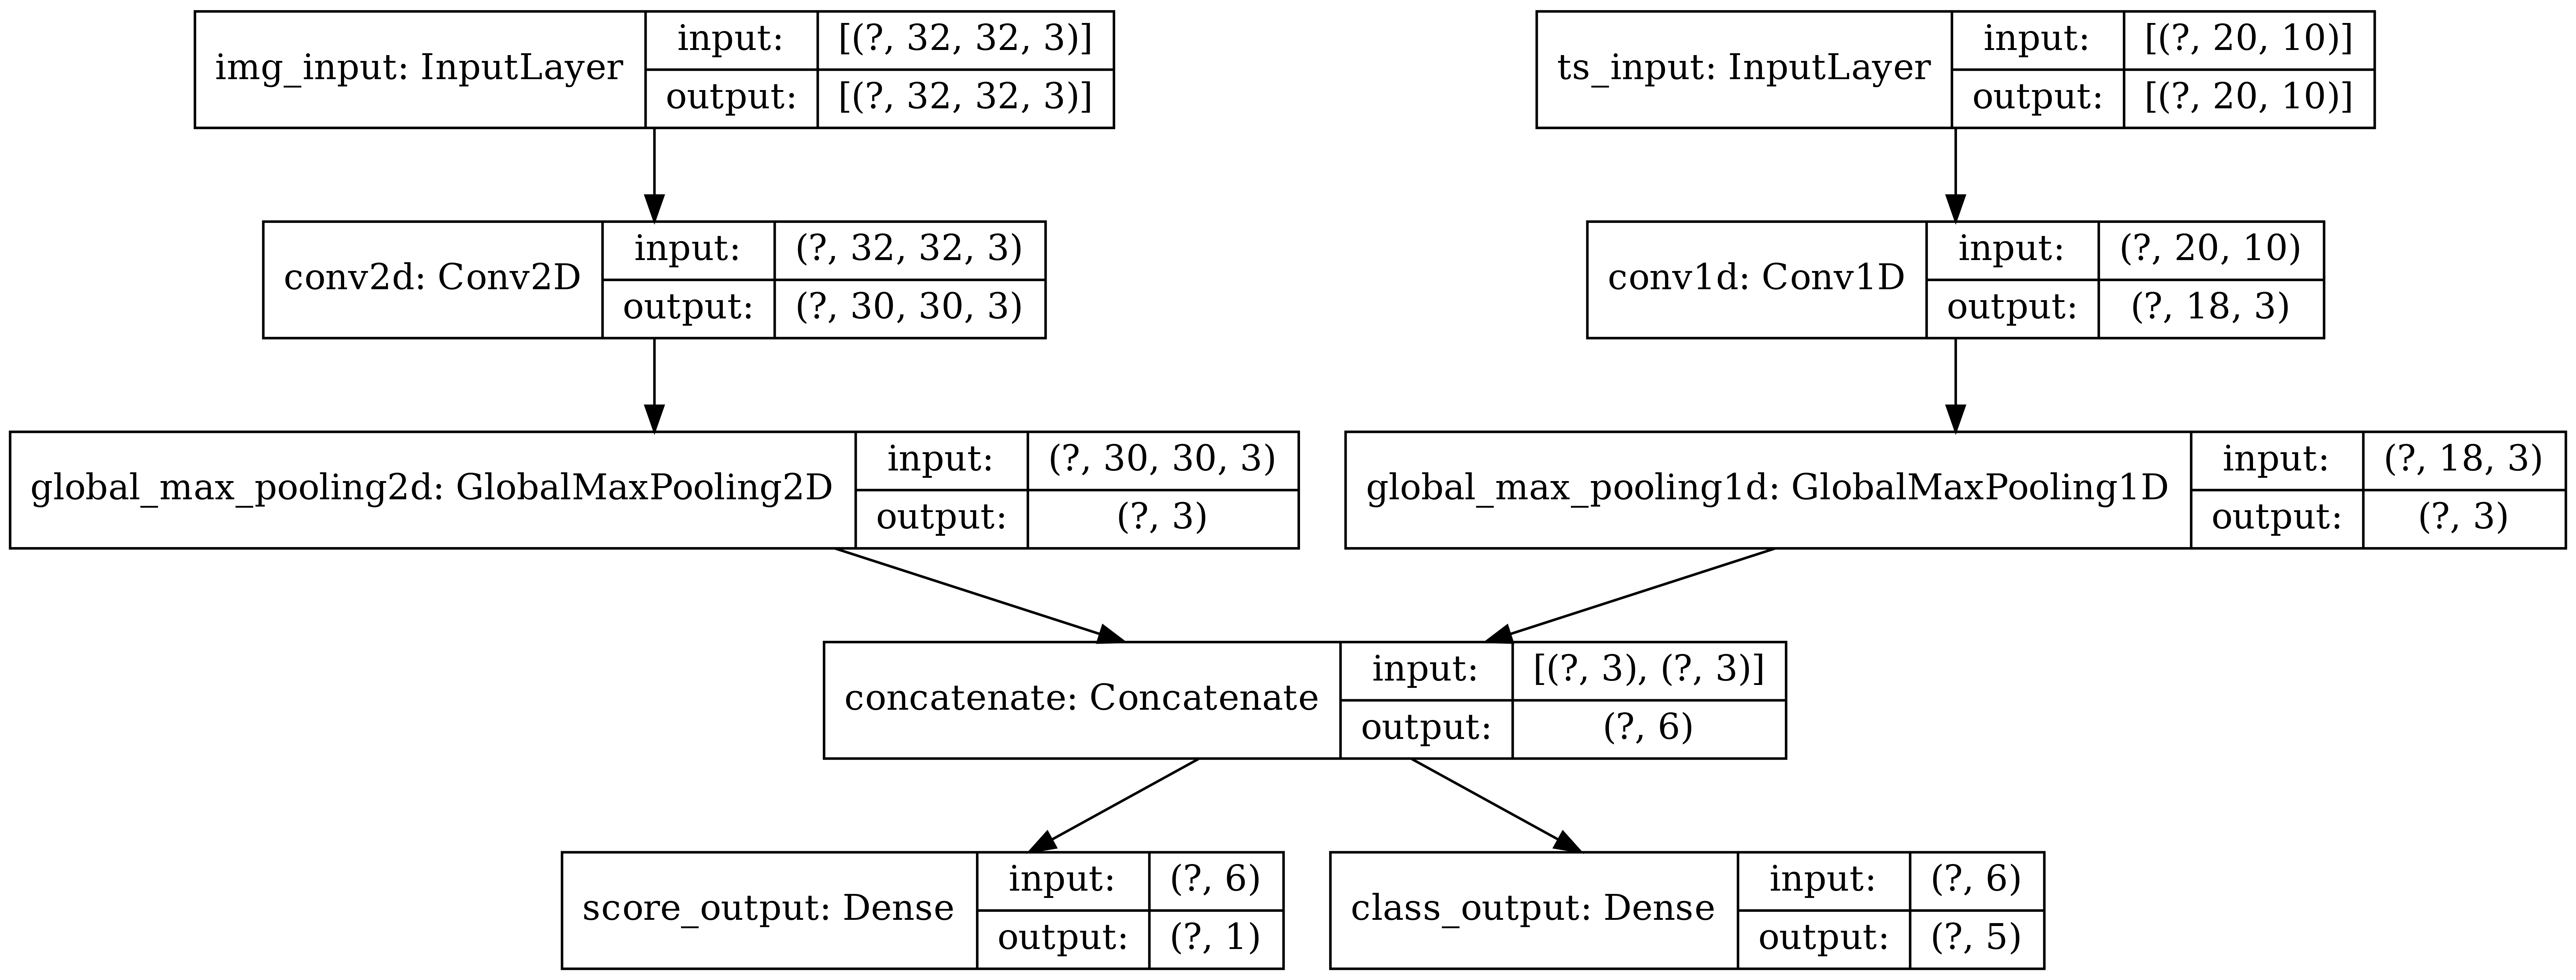

In [46]:
tf.keras.utils.plot_model(model,'multi_input_and_output_model.png',show_shapes=True,dpi = 500)

#### 1.损失函数

通过将损失函数作为列表传递，我们可以为不同的输出定义不同的损失

In [47]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss = [tf.keras.losses.MeanSquaredError(),
    tf.keras.losses.CategoricalCrossentropy(from_logits = True)]
)

#### 2.评估指标函数

In [48]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
        loss = [tf.keras.losses.MeanSquaredError(),
    tf.keras.losses.CategoricalCrossentropy(from_logits = True)],
        metrics = [[tf.keras.metrics.MeanAbsolutePercentageError(),
        tf.keras.metrics.MeanAbsoluteError()],
        [tf.keras.metrics.CategoricalAccuracy()]]
    )

我们为输出层命名以后，还可以通过字典的形式指定每个输出的损失和指标

In [50]:
model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-3),
        loss = {'score_output':tf.keras.losses.MeanSquaredError(),
    'class_output':tf.keras.losses.CategoricalCrossentropy(from_logits = True)},
    metrics = {'score_output':[tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.metrics.MeanAbsoluteError()],
    'class_output':[tf.keras.metrics.CategoricalAccuracy()]}
)

- 如果有两个以上的输出，我们建议使用显式名称和字典
- 可用使用以下参数对不同的特定于输出的损失赋予不同的权重（例如，我们下面这个实例中，我们可能希望将某类损失赋予更高的权重）
- 使用loss_weights参数可以实现该项功能(场景，例如两个模型一并训练的时候，其中一个评估类别，另外一个评估回归问题，那么损失函数就需要加权来表明更加关注哪个分模型的权重和结果)

In [52]:
model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-3),
        loss = {'score_output':tf.keras.losses.MeanSquaredError(),
    'class_output':tf.keras.losses.CategoricalCrossentropy(from_logits = True)},
    metrics = {'score_output':[tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.metrics.MeanAbsoluteError()],
    'class_output':[tf.keras.metrics.CategoricalAccuracy()]},
    loss_weights = {'score_output':2,'class_output':1}
)

#### 八、完整的复现一个模型的实现调包代码

时间：48:24，沿用前面部分的案例数据

In [53]:
# 定义一个图像输入和一个时间序列输入
image_input = tf.keras.Input(shape = (32,32,3),name = 'img_input')
timeseries_input = tf.keras.Input(shape=(20,10),name = 'ts_input')

# 卷积
x1 = tf.keras.layers.Conv2D(3,3)(image_input)
x1 = tf.keras.layers.GlobalMaxPooling2D()(x1)

x2 = tf.keras.layers.Conv1D(3,3)(timeseries_input)
x2 = tf.keras.layers.GlobalMaxPooling1D()(x2)

x = tf.keras.layers.concatenate([x1,x2])

# 一个分数输出，一个是包含5个类别的概率分布输出
score_output = tf.keras.layers.Dense(1,name = 'score_output')(x)
class_output = tf.keras.layers.Dense(5,name = 'class_output')(x)

model = tf.keras.Model(inputs = [image_input,timeseries_input],
    outputs = [score_output,class_output]
)

In [54]:
# 定义优化方法和损失函数
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss = [tf.keras.losses.MeanSquaredError(),
    tf.keras.losses.CategoricalCrossentropy(from_logits = True)]
)

In [55]:
# 生成虚拟的数据用于训练
img_data = np.random.random_sample(size = (100,32,32,3))
ts_data = np.random.random_sample(size = (100,20,10))
score_targets = np.random.random_sample(size = (100,1))
class_targets = np.random.random_sample(size = (100,5))

In [56]:
# 方法一：使用列表传输数据训练
model.fit([img_data,ts_data],[score_targets,class_targets],batch_size = 32, epochs  =3 )

Epoch 1/3
4/4 [==============================] - 0s 11ms/step - loss: 4.5445 - score_output_loss: 0.2531 - class_output_loss: 4.2914
Epoch 2/3
4/4 [==============================] - 0s 4ms/step - loss: 4.5007 - score_output_loss: 0.2086 - class_output_loss: 4.2921
Epoch 3/3
4/4 [==============================] - 0s 4ms/step - loss: 4.4540 - score_output_loss: 0.1702 - class_output_loss: 4.2838


In [57]:
# 方法二：使用字典传输数据训练
model.fit({'img_input':img_data,'ts_input':ts_data},
    {'score_output':score_targets,'class_output':class_targets},
    batch_size = 32,epochs=3
)

Epoch 1/3
4/4 [==============================] - 0s 4ms/step - loss: 4.4714 - score_output_loss: 0.1707 - class_output_loss: 4.3007
Epoch 2/3
4/4 [==============================] - 0s 6ms/step - loss: 4.4815 - score_output_loss: 0.1794 - class_output_loss: 4.3021
Epoch 3/3
4/4 [==============================] - 0s 4ms/step - loss: 4.4954 - score_output_loss: 0.1697 - class_output_loss: 4.3257


In [58]:
# 方法三：使用元祖传输数据训练

In [59]:
model.fit((img_data,ts_data),(score_targets,class_targets),batch_size = 32,epochs=3)

Epoch 1/3
4/4 [==============================] - 0s 4ms/step - loss: 4.5098 - score_output_loss: 0.1694 - class_output_loss: 4.3404
Epoch 2/3
4/4 [==============================] - 0s 4ms/step - loss: 4.5403 - score_output_loss: 0.1706 - class_output_loss: 4.3698
Epoch 3/3
4/4 [==============================] - 0s 4ms/step - loss: 4.5379 - score_output_loss: 0.1621 - class_output_loss: 4.3758


## 问题

- 1.tf.keras.utils.plot_model无法显示可视化的图需要处理。
- 2.MeanAbsolutePercentageError不存在的问题